In [38]:
%matplotlib inline
from scipy import io
from neurodsp import spectral
import os
import datetime
import matplotlib.pyplot as plt
from fooof import FOOOFGroup
import numpy as np
from scipy import signal
import sys

sys.path.append('../')
import utils

In [39]:
basepath = '/Users/rdgao/Documents/data/MNI_rest/'
datafile = basepath + 'WakefulnessMatlabFile.mat'
data_dict = io.loadmat(datafile, squeeze_me = True)
result_basepath = '/Users/rdgao/Documents/code/research/field-echos/results/MNI_rest/'

In [40]:
print(data_dict.keys())
fs = data_dict['SamplingFrequency']
data = data_dict['Data']
sig_len, nchans = data.shape

dict_keys(['__header__', '__version__', '__globals__', 'AgeAtTimeOfStudy', 'ChannelName', 'ChannelPosition', 'ChannelRegion', 'ChannelType', 'Data', 'FacesLeft', 'FacesRight', 'Gender', 'Hemisphere', 'NodesLeft', 'NodesLeftInflated', 'NodesRegionLeft', 'NodesRegionRight', 'NodesRight', 'NodesRightInflated', 'Patient', 'RegionName', 'SamplingFrequency'])


In [41]:
def compute_spectrum_w_holes(data, fs, window, nperseg, noverlap):
    f_axis,t_axis,spg = signal.spectrogram(data, fs, 'hann', nperseg, noverlap)
    psd_mean = spg[:,~np.all(spg==0, axis=0)].mean(1)
    psd_median = np.median(spg[:,~np.all(spg==0, axis=0)],axis=1)
    return f_axis, psd_mean, psd_median

def compute_psds_whole(data, fs, nperseg, noverlap):
    # compute psd and toss slices with holes
    psd_mean = np.zeros((int(nperseg/2+1), nchans))
    psd_med = np.zeros((int(nperseg/2+1), nchans))
    for chan in range(nchans):
        f_axis, psd_mean[:,chan], psd_med[:,chan] = compute_spectrum_w_holes(data[:,chan], fs, 'hann', nperseg, noverlap)
    return f_axis, psd_mean, psd_med

# Compute PSDs
#### 1s window (1Hz)

In [5]:
nperseg, noverlap = int(fs), int(fs/2)
f_axis, psd_mean, psd_med = compute_psds_whole(data, fs, nperseg, noverlap)
saveout_path = utils.makedir(result_basepath, 'psd/1sec/', timestamp=False)
np.savez(saveout_path+'psds.npz', psd_mean=psd_mean, psd_med=psd_med,
         f_axis=f_axis, nperseg=nperseg, noverlap=noverlap)

#### 5s window (0.2Hz)

In [7]:
nperseg, noverlap = int(fs*5), int(fs*4)
f_axis, psd_mean, psd_med = compute_psds_whole(data, fs, nperseg, noverlap)
saveout_path = utils.makedir(result_basepath, '/psd/5sec/', timestamp=False)
np.savez(saveout_path+'psds.npz', psd_mean=psd_mean, psd_med=psd_med,
         f_axis=f_axis, nperseg=nperseg, noverlap=noverlap)

# FOOOFing

In [30]:
fooof_settings = [['knee', 2, (2,55)],
                 ['fixed', 2, (2,55)],
                 ['fixed', 1, (1,10)],
                 ['fixed', 1, (30,55)]]

for psd_win in ['1sec/', '5sec/']:
    psd_folder = result_basepath+'/psd/'+psd_win
    psd_data = np.load(psd_folder+'psds.npz')
    for f_s in fooof_settings:
        fg = FOOOFGroup(background_mode=f_s[0], max_n_peaks=f_s[1])
        fg.fit(psd_data['f_axis'], psd_data['psd_mean'].T, freq_range=f_s[2])
        fooof_savepath = utils.makedir(psd_folder, '/fooof/', timestamp=False)
        fg.save('fg_%s_%ipks_%i-%iHz'%(f_s[0],f_s[1],f_s[2][0],f_s[2][1]), fooof_savepath, save_results=True, save_settings=True)

Running FOOOFGroup across 1772 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1772 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1772 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too 

## workflow
- compute psd -> param var
- fooof -> param var
    - knee vs. no knee
- plot psd & fooof to check for fit
- check results:
- fooof params vs space (discretized and cont)
- fooof params correlation
    - slope, knee, error, r2 (check NT)




## organizational structure

results:
- per dataset
    - psds
        - fooof results with specific parameter combinations
            - dated
        - figures
    - dataset specific results
    - summary figures

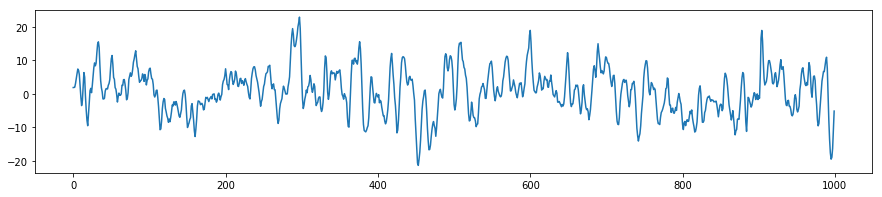

In [55]:
chan=80
plt.figure(figsize=(15,3))
plt.plot(data_dict['Data'][:1000,chan])